# Get Carl's Jr. locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange
from random import randint
from time import sleep
import warnings

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None
warnings.filterwarnings("ignore")

## Read data

#### Get populous ZIP Codes and their lon/lat

In [4]:
zips_src = (
    gpd.read_file("../_reference/data/zips_centroids.geojson")[
        ["ID", "ST_ABBREV", "TOTPOP_CY", "geometry"]
    ]
    .sort_values("TOTPOP_CY", ascending=False)
    .reset_index(drop=True)
)
zips_src.columns = zips_src.columns.str.lower()

In [5]:
zips_src["longitude"] = zips_src.centroid.x
zips_src["latitude"] = zips_src.centroid.y

#### Limit to states where Carl's Jr operates

In [6]:
states = ["CA", "AZ", "OR", "CO", "NV", "UT", "OK", "WA", "TX", "ID"]

In [7]:
zips = zips_src[zips_src["st_abbrev"].isin(states)].copy()

In [8]:
zips.head()

,id,st_abbrev,totpop_cy,geometry,longitude,latitude
0,77494,TX,128751,POINT (-95.82624 29.74476),-95.826244,29.744760
1,77449,TX,118772,POINT (-95.73768 29.83612),-95.737683,29.836123
4,79936,TX,114053,POINT (-106.29538 31.76576),-106.295381,31.765758
5,90011,CA,110666,POINT (-118.25880 34.00707),-118.258798,34.007070
6,77084,TX,110167,POINT (-95.64832 29.82624),-95.648321,29.826244


---

#### Set up requests

In [9]:
import requests

cookies = {
    "_gcl_au": "1.1.516157714.1706369182",
    "OptanonConsent": "isGpcEnabled=0&datestamp=Sat+Jan+27+2024+07%3A26%3A21+GMT-0800+(Pacific+Standard+Time)&version=202301.1.0&isIABGlobal=false&hosts=&consentId=e826d9d7-168a-46eb-be52-07b4bfff3bdf&interactionCount=0&landingPath=https%3A%2F%2Fwww.carlsjr.com%2Flocations&groups=C0003%3A1%2CC0004%3A1%2CC0002%3A1%2CC0001%3A1",
    "_rdt_uuid": "1706369181864.ccf9a890-65b3-43e2-93b2-fcc91f0ecb69",
    "_scid": "974037f8-067a-4136-936c-17b08ded25c5",
    "_scid_r": "974037f8-067a-4136-936c-17b08ded25c5",
    "_derived_epik": "dj0yJnU9NW8wc1EzeDFJWUVVbmY5b0NIRmdRZEJpNGY5bVRCdjQmbj1hZUpXdXJfS01oNHpwc3BYV0xVb2hRJm09MSZ0PUFBQUFBR1cxSUo0JnJtPTEmcnQ9QUFBQUFHVzFJSjQmc3A9Mg",
    "_pin_unauth": "dWlkPU5UQXdaRGd3WlRNdE5qRTVNeTAwWWpkaUxUazNPVGt0T0dKak0yTmxOR014WkdZeA",
    "_fbp": "fb.1.1706369182427.574499949",
    "_gid": "GA1.2.2137922063.1706369182",
    "_dc_gtm_UA-168018701-6": "1",
    "_tq_id.TV-7209093654-1.221e": "243b8ae9a1246d2e.1706369182.0.1706369182..",
    "_tt_enable_cookie": "1",
    "_ttp": "70fl9xnW-KVCgGwM-jDR3L1nnR8",
    "_ga_LHYVJB2PVQ": "GS1.2.1706369182.1.0.1706369182.0.0.0",
    "_ga": "GA1.1.354940790.1706369182",
    "_ga_2Y3L4YDWMY": "GS1.1.1706369182.1.0.1706369183.0.0.0",
    "_sctr": "1%7C1706342400000",
}

headers = {
    "authority": "www.carlsjr.com",
    "accept": "*/*",
    "accept-language": "en-US,en;q=0.9,es;q=0.8",
    # 'cookie': '_gcl_au=1.1.516157714.1706369182; OptanonConsent=isGpcEnabled=0&datestamp=Sat+Jan+27+2024+07%3A26%3A21+GMT-0800+(Pacific+Standard+Time)&version=202301.1.0&isIABGlobal=false&hosts=&consentId=e826d9d7-168a-46eb-be52-07b4bfff3bdf&interactionCount=0&landingPath=https%3A%2F%2Fwww.carlsjr.com%2Flocations&groups=C0003%3A1%2CC0004%3A1%2CC0002%3A1%2CC0001%3A1; _rdt_uuid=1706369181864.ccf9a890-65b3-43e2-93b2-fcc91f0ecb69; _scid=974037f8-067a-4136-936c-17b08ded25c5; _scid_r=974037f8-067a-4136-936c-17b08ded25c5; _derived_epik=dj0yJnU9NW8wc1EzeDFJWUVVbmY5b0NIRmdRZEJpNGY5bVRCdjQmbj1hZUpXdXJfS01oNHpwc3BYV0xVb2hRJm09MSZ0PUFBQUFBR1cxSUo0JnJtPTEmcnQ9QUFBQUFHVzFJSjQmc3A9Mg; _pin_unauth=dWlkPU5UQXdaRGd3WlRNdE5qRTVNeTAwWWpkaUxUazNPVGt0T0dKak0yTmxOR014WkdZeA; _fbp=fb.1.1706369182427.574499949; _gid=GA1.2.2137922063.1706369182; _dc_gtm_UA-168018701-6=1; _tq_id.TV-7209093654-1.221e=243b8ae9a1246d2e.1706369182.0.1706369182..; _tt_enable_cookie=1; _ttp=70fl9xnW-KVCgGwM-jDR3L1nnR8; _ga_LHYVJB2PVQ=GS1.2.1706369182.1.0.1706369182.0.0.0; _ga=GA1.1.354940790.1706369182; _ga_2Y3L4YDWMY=GS1.1.1706369182.1.0.1706369183.0.0.0; _sctr=1%7C1706342400000',
    "referer": "https://www.carlsjr.com/locations",
    "sec-ch-ua": '"Not_A Brand";v="8", "Chromium";v="120", "Google Chrome";v="120"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"macOS"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-origin",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "x-requested-with": "XMLHttpRequest",
}

#### Loop through the list to set a search radius in each ZIP

In [10]:
restaurant_list = []

for k, v in tqdm(zips.head(500).iterrows()):

    params = {
        "Latitude": v["latitude"],
        "Longitude": v["longitude"],
        "Radius": "100",
    }

    response = requests.get(
        "https://www.carlsjr.com/api/locationapi",
        params=params,
        cookies=cookies,
        headers=headers,
    )

    data = pd.DataFrame(response.json()["locations"])
    restaurant_list.append(data)

0it [00:00, ?it/s]

#### Dataframe from list

In [11]:
src = pd.concat(restaurant_list)

#### Clean up

In [12]:
src["id"] = (
    src["fullDisplayAddress"]
    .str.split(" - ", expand=True)[0]
    .str.replace("Restaurant ", "")
    .str.strip()
    .astype(str)
)

src["zipCode"] = src["zipCode"].str[:5]

#### Just the columns we need

In [24]:
df = (
    src[
        [
            "id",
            "address",
            "city",
            "state",
            "zipCode",
            "phoneNumber",
            "orderUrl",
            "latitude",
            "longitude",
        ]
    ]
    .drop_duplicates()
    .copy()
    .rename(columns={"zipCode": "zip", "phoneNumber": "phone", "orderUrl": "url"})
)

In [25]:
df.head()

,id,address,city,state,zip,phone,url,latitude,longitude
0,1102092,6709 US HWY 90,SEALY,TX,77474,(979) 732-2986,None,29.742653,-96.330407
1,1102518,2301 FM 523,ANGLETON,TX,77515,(979) 849-5936,None,29.196469,-95.456736
0,1101552,1898 N LEE TREVINO DR,EL PASO,TX,79936,(915) 595-0924,https://order.carlsjr.com/location/-tx-el-paso-1898-n-lee-trevino-dr/menu,31.768490,-106.318610
1,1101354,1490 N ZARAGOZA RD,EL PASO,TX,79936,(915) 921-1504,https://order.carlsjr.com/location/-tx-el-paso-1490-n-zaragoza-rd/menu,31.737450,-106.291710
2,1101790,10620 MONTANA AVE,EL PASO,TX,79935,(915) 591-4250,https://order.carlsjr.com/location/-tx-el-paso-10620-montana-ave/menu,31.797740,-106.330810


In [26]:
df.tail()

,id,address,city,state,zip,phone,url,latitude,longitude
14,1101187,502 E MAIN ST,FLORENCE,CO,81226,(719) 784-4600,https://order.carlsjr.com/location/-co-florence-502-e-main-st/menu,38.38835,-105.11155
15,1101192,915 W US HIGHWAY 50,PUEBLO,CO,81008,(719) 543-0606,https://order.carlsjr.com/location/-co-pueblo-915-w-us-highway-50/menu,38.30855,-104.62116
17,1101191,102 S SANTA FE AVE,PUEBLO,CO,81003,(719) 544-9618,https://order.carlsjr.com/location/-co-pueblo-102-s-santa-fe-ave/menu,38.26768,-104.60642
18,1101692,1759 S PUEBLO BLVD,PUEBLO,CO,81005,(719) 566-7958,https://order.carlsjr.com/location/-co-pueblo-1759-s-pueblo-blvd/menu,38.23636,-104.66285
18,1100114,344 W MANCHESTER,INGLEWOOD,CA,90301,(310) 671-1686,None,33.96132,-118.36134


In [27]:
len(df.drop_duplicates())

1026

---

## Geography

#### Read list of story dictionaries into dataframe

In [28]:
geo_df = df.copy()

#### Make a geodataframe from lon/lat

In [29]:
gdf = gpd.GeoDataFrame(
    geo_df, geometry=gpd.points_from_xy(geo_df.longitude, geo_df.latitude)
).set_crs("epsg:4326")

<AxesSubplot: >

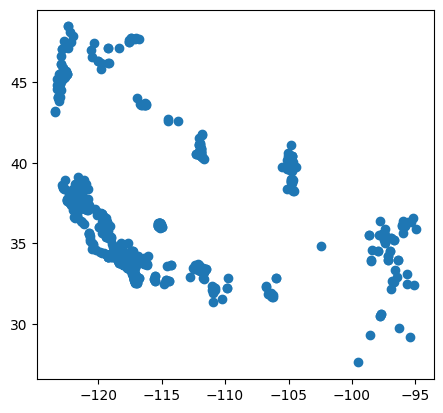

In [30]:
gdf.plot()

---

## Exports

#### CSV

In [18]:
df.to_csv("data/processed/vons_locations.csv", index=False)

#### JSON

In [19]:
df.to_json("data/processed/vons_locations.json", indent=4, orient="records")

#### GeoJSON

In [20]:
gdf.to_file("data/processed/vons_locations.geojson", driver="GeoJSON")